In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

# Optical absorption of the Stanene monolayer

We study the optical absorption spectrum.

## IP absorption on top of the DFT analysis

We study the absorption spectrum on top of the DFT analysis in function of the k-points sampling.

In [4]:
ksamplings = {'18x18x1': {'folder':'kpoints_18-nbnds_600','K_index':37,'G_index':1},
             '60x60x1': {'folder':'kpoints_60-nbnds_600','K_index':331,'G_index':1},
             '72x72x1': {'folder':'kpoints_72-nbnds_600','K_index':469,'G_index':1},
            }

start_band,stop_band = 28,29

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    file = os.path.join(run_dir,'pp-K-kpoints_%s'%kpoints,'o-pp-K-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file)
    ksamplings[kpoints]['gw_gap'] = data.get_gap(k_full=ksamplings[kpoints]['K_index'],band_full=start_band,verbose=False)
#ksamplings

Parse file MB_analysis/kpoints_18-nbnds_600/pp-K-kpoints_18x18x1/o-pp-K-kpoints_18x18x1.qp
Parse file MB_analysis/kpoints_60-nbnds_600/pp-K-kpoints_60x60x1/o-pp-K-kpoints_60x60x1.qp
Parse file MB_analysis/kpoints_72-nbnds_600/pp-K-kpoints_72x72x1/o-pp-K-kpoints_72x72x1.qp


In [5]:
RandGvec = 100
RandQpts = 5e6

dft_gap = 0.0883 # eV

energy_range = [-1,3] # eV
damping = [0.05,0.05] # eV
BLongDir = [1.0,1.0,0.0] # in-plane electric field

study = D.Dataset(num_tasks=3,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    inp = I.YamboInput('yambo -r -o b -k IP',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BLongDir=BLongDir)
    idd = 'abs-ip-kpoints_%s'%kpoints
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,'ndbs'])

Initialize a Dataset with 3 parallel tasks


In [8]:
#study.runs[0]

In [10]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
Skip the run of abs-ip-kpoints_60x60x1
Skip the run of abs-ip-kpoints_18x18x1
Skip the run of abs-ip-kpoints_72x72x1
Task [0, 1, 2] ended 
 


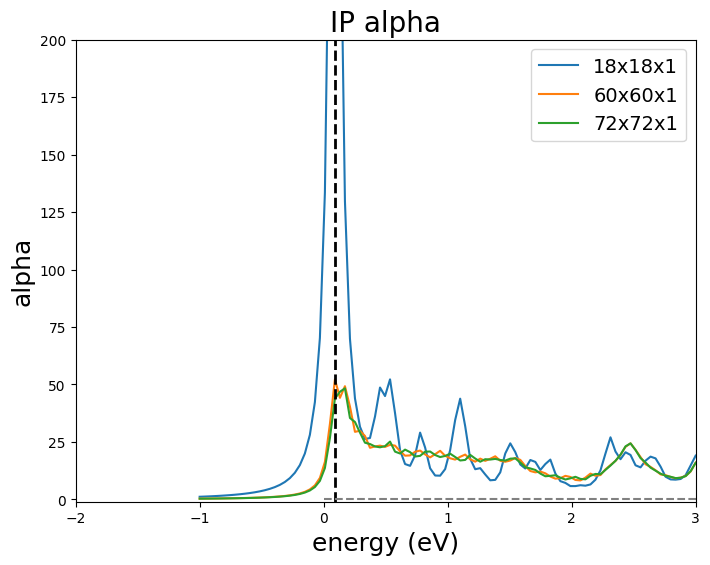

In [13]:
kpoints = [k for k in ksamplings]

fig, ax = plt.subplots(figsize=(8, 6))
for ind,k in enumerate(kpoints):
    data = results[ind].data['alpha_q1_IP']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label=k) 
ax.vlines(dft_gap,-1,3000,linestyles='--',color='black',linewidth=2)
ax.hlines(0,xmin=0,xmax=energy[-1],linestyles='--',color='gray')
ax.set_xlim(-2,3)
ax.set_ylim(-1,200)
ax.set_ylabel('alpha',size=18)
ax.set_xlabel('energy (eV)',size=18)
ax.set_title('IP alpha',size=20)
ax.legend(fontsize=14)

## BSE Analysis

In [14]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

We perform the BSE analysis to compute the absorption spectrum and the excitonic energies.

We perform this analysis for various values of the relevant paramters and k-samplings to check the convergence 
of the BSE results. Computations are performed by including a scissor provided by the GW correction at the $\Gamma$ point to the DFT KS energies

In [15]:
ksamplings = {'18x18x1': {'folder':'kpoints_18-nbnds_600','K_index':37,'G_index':1},
             '60x60x1': {'folder':'kpoints_60-nbnds_600','K_index':331,'G_index':1},
             '72x72x1': {'folder':'kpoints_72-nbnds_600','K_index':469,'G_index':1},
            }

start_band,stop_band = 28,29

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    file = os.path.join(run_dir,'pp-K-kpoints_%s'%kpoints,'o-pp-K-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file)
    ksamplings[kpoints]['gw_gap'] = data.get_gap(k_full=ksamplings[kpoints]['K_index'],band_full=start_band,verbose=False)
#ksamplings

Parse file MB_analysis/kpoints_18-nbnds_600/pp-K-kpoints_18x18x1/o-pp-K-kpoints_18x18x1.qp
Parse file MB_analysis/kpoints_60-nbnds_600/pp-K-kpoints_60x60x1/o-pp-K-kpoints_60x60x1.qp
Parse file MB_analysis/kpoints_72-nbnds_600/pp-K-kpoints_72x72x1/o-pp-K-kpoints_72x72x1.qp


### Convergence of the BSEBands and of the BSENGBlk parameter

First we test the effects of the number of BSE bands and of the cutoff in the BSE matrix in the smaller k-sampling.

We start by performing a convergence test on the BSENGBlk parameter with 12 bands from 23 to 34 (6 full and 6 empties) in the BSE matrix.

In [17]:
kpoints = '18x18x1'
run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = [3.0,4.0] # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,1.,0.]
BSEBands = [23,34]  # [23,28]
BEnRange = [-1.,3] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.05,0.05] # eV

dft_gap = 0.0883 # eV
scissor = ksamplings[kpoints]['gw_gap'] - dft_gap

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -rw -o b -k sex -y s',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig) #,BSSSlepcMaxIt=BSSSlepcMaxIt
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping) #,BSSEnTarget=BSSEnTarget
inp.set_scalar_variables(BSEprop= 'abs esrt') # esrt
#inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='4.1.1',BS_ROLEs= 'k.eh.t') # 1 nodes on leonardo  
#inp.set_scalar_variables(BS_CPU='16.1.1',BS_ROLEs= 'k.eh.t') # 4 nodes on leonardo  

for bsengblk in BSENGBlk:
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=bsengblk,FFTGvecs=FFTGvecs)
    idd = 'abs-bse-bsengblk_%s-bands_%s-%s'%(bsengblk,BSEBands[0],BSEBands[1])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_600','ndbs'],reformat=False)

Initialize a Dataset with 2 parallel tasks


In [22]:
study.ids

['abs-bse-bsengblk_3.0-bands_23-34', 'abs-bse-bsengblk_4.0-bands_23-34']

In [23]:
#study.runs[0]

In [24]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core yambo -F abs-bse-bsengblk_3.0-bands_23-34.in -J "abs-bse-bsengblk_3.0-bands_23-34,ndb_em1d-ngsblkxp_8.0-bndsrnxp_600,ndbs" -C abs-bse-bsengblk_3.0-bands_23-34
slurm submit: run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core yambo -F abs-bse-bsengblk_4.0-bands_23-34.in -J "abs-bse-bsengblk_4.0-bands_23-34,ndb_em1d-ngsblkxp_8.0-bndsrnxp_600,ndbs" -C abs-bse-bsengblk_4.0-bands_23-34 cd MB_analysis/kpoints_18-nbnds_600 ; sbatch job_abs-bse-bsengblk_3.0-bands_23-34.sh

computation abs-bse-bsengblk_3.0-bands_23-34 is running...slurm submit: 
 cd MB_analysis/kpoints_18-nbnds_600 ; sbatch job_abs-bse-bsengblk_4.0-bands_23-34.sh
computation abs-bse-bsengblk_4.0-bands_23-34 is running...
computation abs-bse-bsengblk_4.0-bands_23-34 ended
Run performed in 23m-33s
computation abs-bse-bsengblk_3.0-bands_23-34 ended
Run performed in 24m-27s
T

In [25]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.121072, 0.1227  , 0.125504, 0.48455 , 0.486502, 0.516155,
       0.51728 , 0.551331, 0.561738])

In [26]:
exc_eng = results[1].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.121075, 0.1227  , 0.125504, 0.484542, 0.486493, 0.516181,
       0.517305, 0.551333, 0.561744])

In [27]:
bind_eng = ksamplings[kpoints]['gw_gap']-exc_eng[0]
bind_eng

0.07009899999999995

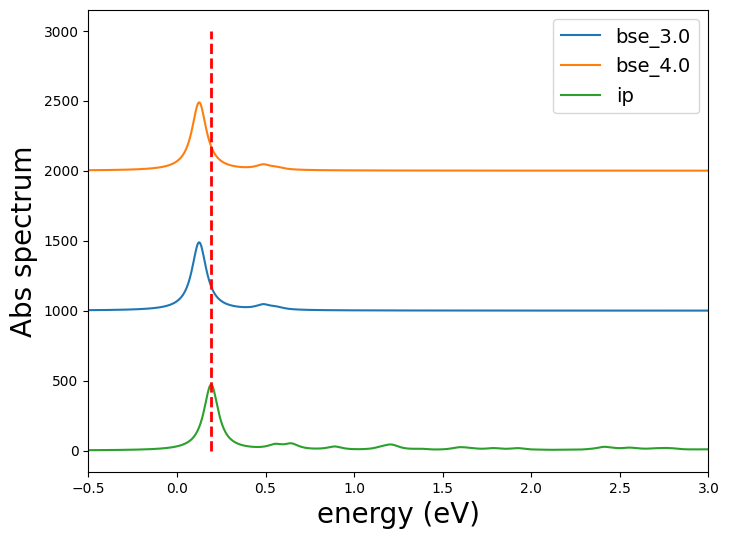

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

for ind in range(len(BSENGBlk)):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    eps_im = data['alpha_imag']
    ax.plot(energy,(ind+1)*1000+eps_im,label='bse_%s'%BSENGBlk[ind])
eps_o_im = data['alpha_o_imag']
ax.plot(energy,eps_o_im,label='ip') 
ax.vlines(ksamplings[kpoints]['gw_gap'],-1,3000,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,3)
#ax.set_ylim(-1,500)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

On the basis of this analysis it turns out BSENGBlk = 3 Ha is sufficient for the convergence of both the excitation energies and of the associated polarizability.

Then we explore the converge on the bands parameter.

In [36]:
kpoints = '18x18x1'
run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,1.,0.]
BSEBands = [[27,30],[23,34],[21,36]] 
BEnRange = [-1.,3] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.05,0.05] # eV

dft_gap = 0.0883 # eV
scissor = ksamplings[kpoints]['gw_gap'] - dft_gap

study = D.Dataset(num_tasks=3,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -rw -o b -k sex -y s',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping) 
inp.set_scalar_variables(BSEprop= 'abs esrt') # esrt
#inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='4.1.1',BS_ROLEs= 'k.eh.t') # 1 nodes on leonardo  
#inp.set_scalar_variables(BS_CPU='16.1.1',BS_ROLEs= 'k.eh.t') # 4 nodes on leonardo  

for bands in BSEBands:
    inp.set_array_variables(BSEBands=bands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    idd = 'abs-bse-bsengblk_%s-bands_%s-%s'%(BSENGBlk,bands[0],bands[1])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_600','ndbs'],reformat=False)

Initialize a Dataset with 3 parallel tasks


In [37]:
study.ids

['abs-bse-bsengblk_3.0-bands_27-30',
 'abs-bse-bsengblk_3.0-bands_23-34',
 'abs-bse-bsengblk_3.0-bands_21-36']

In [38]:
#study.runs[0]

In [40]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
Skip the run of abs-bse-bsengblk_3.0-bands_21-36
Skip the run of Skip the run ofabs-bse-bsengblk_3.0-bands_27-30 
abs-bse-bsengblk_3.0-bands_23-34
Task [0, 1, 2] ended 
 


In [41]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.121531, 0.122732, 0.125556, 0.485145, 0.486944, 0.520623,
       0.551372, 0.561782])

In [42]:
exc_eng = results[1].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.121072, 0.1227  , 0.125504, 0.48455 , 0.486502, 0.516155,
       0.51728 , 0.551331, 0.561738])

In [43]:
exc_eng = results[2].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.121019, 0.122681, 0.125472, 0.484519, 0.486453, 0.515771,
       0.51691 , 0.551311, 0.561727])

In [44]:
bind_eng = ksamplings[kpoints]['gw_gap']-exc_eng[0]
bind_eng

0.07015499999999995

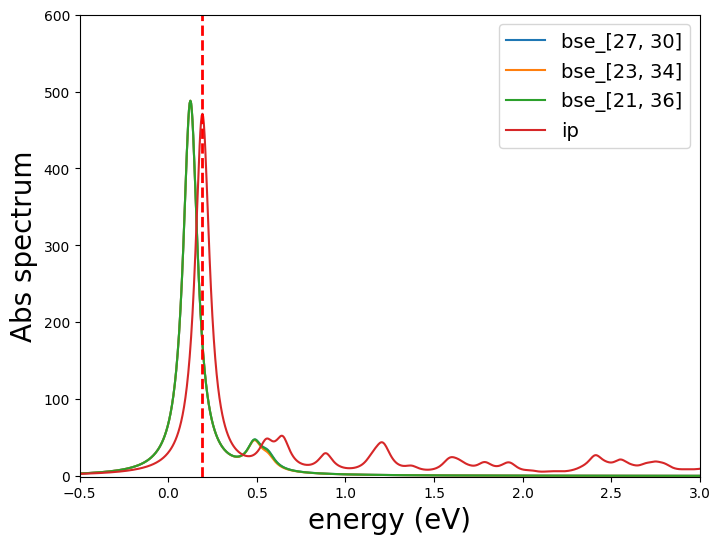

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))

for ind in range(len(BSEBands)):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    eps_im = data['alpha_imag']
    ax.plot(energy,eps_im,label='bse_%s'%BSEBands[ind])
eps_o_im = data['alpha_o_imag']
ax.plot(energy,eps_o_im,label='ip') 
ax.vlines(ksamplings[kpoints]['gw_gap'],-1,8000,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,3)
ax.set_ylim(-1,600)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

The low energy spectrum is converged with bands from 27 to 30

### Convergence in terms of the k-sampling

We investigate the convergence of the BSE spectrum and excitonic energies in function of the k-points samplings.

In [3]:
# RunRules for leonardo
nodes = 4
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 4,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

In [4]:
ksamplings = {'18x18x1': {'folder':'kpoints_18-nbnds_600','K_index':37,'G_index':1},
             '60x60x1': {'folder':'kpoints_60-nbnds_600','K_index':331,'G_index':1},
             '72x72x1': {'folder':'kpoints_72-nbnds_600','K_index':469,'G_index':1},
            }

start_band,stop_band = 28,29

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    file = os.path.join(run_dir,'pp-K-kpoints_%s'%kpoints,'o-pp-K-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file)
    ksamplings[kpoints]['gw_gap'] = data.get_gap(k_full=ksamplings[kpoints]['K_index'],band_full=start_band,verbose=False)
#ksamplings

Parse file MB_analysis/kpoints_18-nbnds_600/pp-K-kpoints_18x18x1/o-pp-K-kpoints_18x18x1.qp
Parse file MB_analysis/kpoints_60-nbnds_600/pp-K-kpoints_60x60x1/o-pp-K-kpoints_60x60x1.qp
Parse file MB_analysis/kpoints_72-nbnds_600/pp-K-kpoints_72x72x1/o-pp-K-kpoints_72x72x1.qp


For this analysis we use the converged values

BSENGBlk = 3.0 # Ha  
BSEBands = [27,30]

In [5]:
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,1.,0.]
BSEBands = [27,30]  
BEnRange = [-1,3] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.05,0.05] # eV

dft_gap = 0.0883 # eV
scissor = ksamplings[kpoints]['gw_gap'] - dft_gap

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    scissor = ksamplings[kpoints]['gw_gap'] - dft_gap
    inp = I.YamboInput('yambo -r -rw -o b -k sex -y s',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping) #,BSSEnTarget=BSSEnTarget
    inp.set_scalar_variables(BSEprop= 'abs esrt') # esrt
    #inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
    #inp.set_scalar_variables(BS_CPU='4.1.1',BS_ROLEs= 'k.eh.t') # 1 nodes on leonardo  
    inp.set_scalar_variables(BS_CPU='16.1.1',BS_ROLEs= 'k.eh.t') # 4 nodes on leonardo  
    inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    idd = 'abs-bse-bsengblk_%s-bands_%s-%s-kpoints_%s'%(BSENGBlk,BSEBands[0],BSEBands[1],kpoints)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_600','ndbs',
                 'abs-bse-bsengblk_3.0-bands_27-30'],reformat=False)

Initialize a Dataset with 4 parallel tasks


In [6]:
study.ids

['abs-bse-bsengblk_3.0-bands_27-30-kpoints_18x18x1',
 'abs-bse-bsengblk_3.0-bands_27-30-kpoints_60x60x1',
 'abs-bse-bsengblk_3.0-bands_27-30-kpoints_72x72x1']

In [7]:
#study.runs[2]

In [8]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
delete job_out script: MB_analysis/kpoints_60-nbnds_600/job_abs-bse-bsengblk_3.0-bands_27-30-kpoints_60x60x1.out
run command: mpirun -np 16 --map-by socket:PE=8 --rank-by core yambo -F abs-bse-bsengblk_3.0-bands_27-30-kpoints_60x60x1.in -J "abs-bse-bsengblk_3.0-bands_27-30-kpoints_60x60x1,ndb_em1d-ngsblkxp_8.0-bndsrnxp_600,ndbs,abs-bse-bsengblk_3.0-bands_27-30" -C abs-bse-bsengblk_3.0-bands_27-30-kpoints_60x60x1
slurm submit:  cd MB_analysis/kpoints_60-nbnds_600 ; sbatch job_abs-bse-bsengblk_3.0-bands_27-30-kpoints_60x60x1.sh
computation abs-bse-bsengblk_3.0-bands_27-30-kpoints_60x60x1 is running...
Skip the run of abs-bse-bsengblk_3.0-bands_27-30-kpoints_72x72x1
delete job_out script: MB_analysis/kpoints_18-nbnds_600/job_abs-bse-bsengblk_3.0-bands_27-30-kpoints_18x18x1.out
delete folder: MB_analysis/kpoints_18-nbnds_600/abs-bse-bsengblk_3.0-bands_27-30-kpoints_18x18x1
run command: mpirun -n

In [9]:
kpoints = [k for k in ksamplings]
exc_ind = 0 # index of the excitation. 0 = first excitation energy
excitations = []
for ind in range(len(kpoints)):
    excitations.append(results[ind].data['Esort_q1_slepc_bse']['energy'][exc_ind])
excitations

[0.121531, 0.101356, 0.105529]

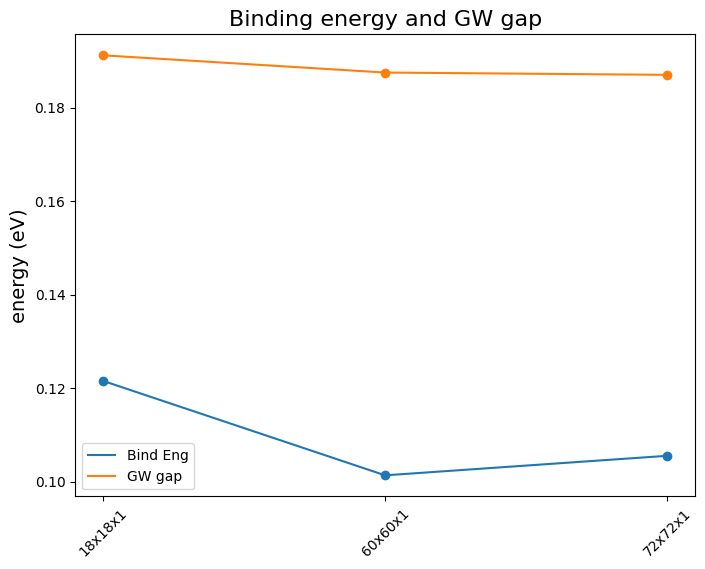

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(kpoints,excitations)
ax.plot(kpoints,excitations,label='Bind Eng')
gw_gaps = [ksamplings[k]['gw_gap'] for k in ksamplings]
ax.scatter(kpoints,gw_gaps)
ax.plot(kpoints,gw_gaps,label='GW gap')
labels = list(ksamplings.keys())
plt.xticks(np.arange(len(kpoints)), kpoints, rotation=45,size=10)
ax.set_title('Binding energy and GW gap',size=16)
ax.set_ylabel('energy (eV)',size=14)
ax.legend()
#ax.set_ylim(0.42,0.55)

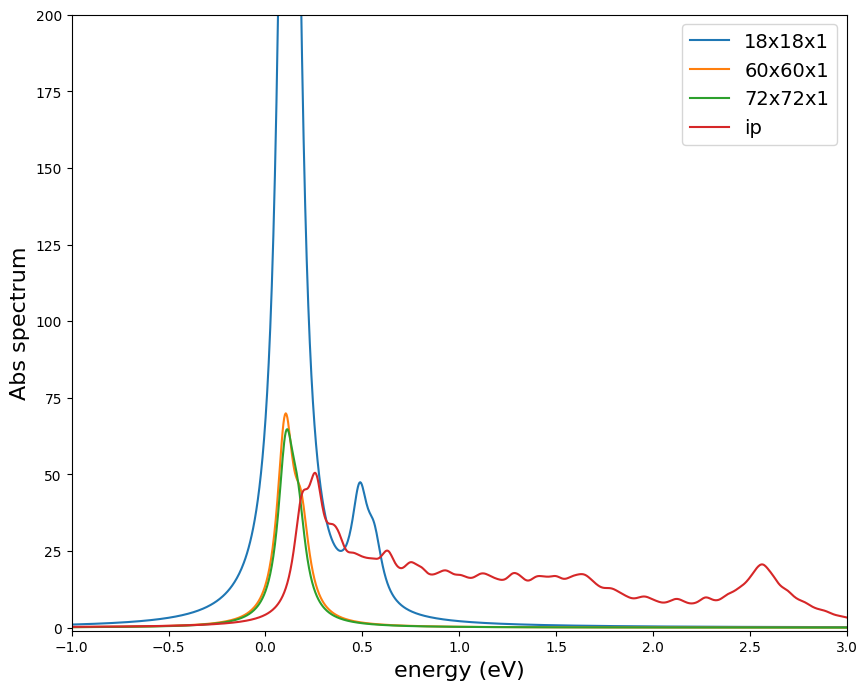

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind in range(len(kpoints)):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    eps_im = data['alpha_imag']
    ax.plot(energy,eps_im,label=kpoints[ind])
eps_o_im = data['alpha_o_imag']
ax.plot(energy,eps_o_im,label='ip') 
#ax.vlines(ksamplings[kpoints]['gw_gap'],-1,120,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-1,3)
ax.set_ylim(-1,200)
ax.set_ylabel('Abs spectrum',size=16)
ax.set_xlabel('energy (eV)',size=16)
ax.legend(fontsize=14)